(The Readme File): 

The spline-based model has a lot of inputs. Below is a list of how they affect the outputted graph:

Model variables: These variables affect the output of the given graph

Ticker: the ticker name from Yahoo Finance Taylor degree: the Taylor degree of each spline (make sure to reset data if changing it) Num_of_nodes: the number of splines within the graph Interval_length: the time interval each spline runs for (measured in days)] Weights: KNN weights (affect the entropy of training data) Moving average: Moving average applied to raw data + derivatives

Parameter selection: These variables affect where the graph begins

Use_rand_params: If set to true, the model will use a random row of data from the training data Use_row_num: If set to true, the model will use the directed row number Use_init_params: Allows for custom initial params (must be similar to weights)

Data preprocessing These variables affect how the data is processed

Ticker: adds and processes the given ticker Taylor degree: determines the number of derivatives taken Weights: KNN weights (affect the entropy of training data) Moving average: Moving average applied to raw data + derivatives Start date: The start date of the imported data from Yahoo Finance End date: The end date of the imported data from Yahoo Finance

In [14]:
#import the Necessary Libraries

#python files in project folder
import model
import data_handler as dh
import model_analysis

#data analysis and storage tools
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import os

#Usual tools
import math
import numpy as np
import matplotlib.pyplot as plt

#note: you need to install yfinance with terminal, or data_handler will throw an error

In [15]:
# Define the function to validate the inputs later on

def validate_inputs():
    """Validates input parameters to avoid most errors."""
    if sum([use_rand_params, use_row_num, use_init_params]) != 1:
        raise ValueError("Set exactly one of Use_rand_params, Use_row_num, or Use_init_params to True.")

    if not isinstance(interval_length, int) or interval_length < 1:
        raise ValueError("Interval length must be a positive integer.")

    if not isinstance(num_of_nodes, int) or num_of_nodes < 1:
        raise ValueError("Number of nodes must be a positive integer.")

    if not isinstance(taylor_degree, int) or taylor_degree < 0:
        raise ValueError("Taylor degree must be a non-negative integer.")

    if weights is None:
        pass
    elif not len(weights) == taylor_degree+1:
        raise(f"Length of Weights must equal one more than the taylor degree. Length of weights is {len(Weights)}")

This first cell will allow you to input parameters into the model to predict the market day of one of three tickers. This cell will call the functions in model.py and data_handler.py to process the data, fit KNN, build the spline model, and graph the results.

[*********************100%%**********************]  1 of 1 completed


Axes(0.125,0.11;0.775x0.77)
Node 0
Domain: (np.float64(3000.0), np.float64(3001.0))
Range: (np.float64(12021.540039062498), np.float64(12082.732340494791))
Output parameters: [12021.54003906    75.09092882   -32.50868056    19.72102865
   -71.70594618   246.79470486]
Nth derivatives at endpoint: [12082.73234049    51.26222399   -13.68976526    48.2340549
   125.72981766   246.79470407]
Distances to nearest neighbors: [[0.         0.02079971 0.02152323 0.02678833 0.02707286 0.02740913
  0.02889879 0.03203604 0.03409377]]
Indices of nearest neighbors: [[3000 1727 2823 2881 2798 2792 1803 2826 2822]]
Node 1
Domain: (np.float64(3001.0), np.float64(3002.0))
Range: (np.float64(12082.732340494791), np.float64(12121.879337565102))
Output parameters: [12082.73234049    49.91232639   -19.46690538   -20.34505208
   108.25021701  -258.17523872]
Nth derivatives at endpoint: [12121.87933757    28.93049326   -25.40782879   -21.92089166
   -98.28997398  -258.17524038]
Distances to nearest neighbors: [

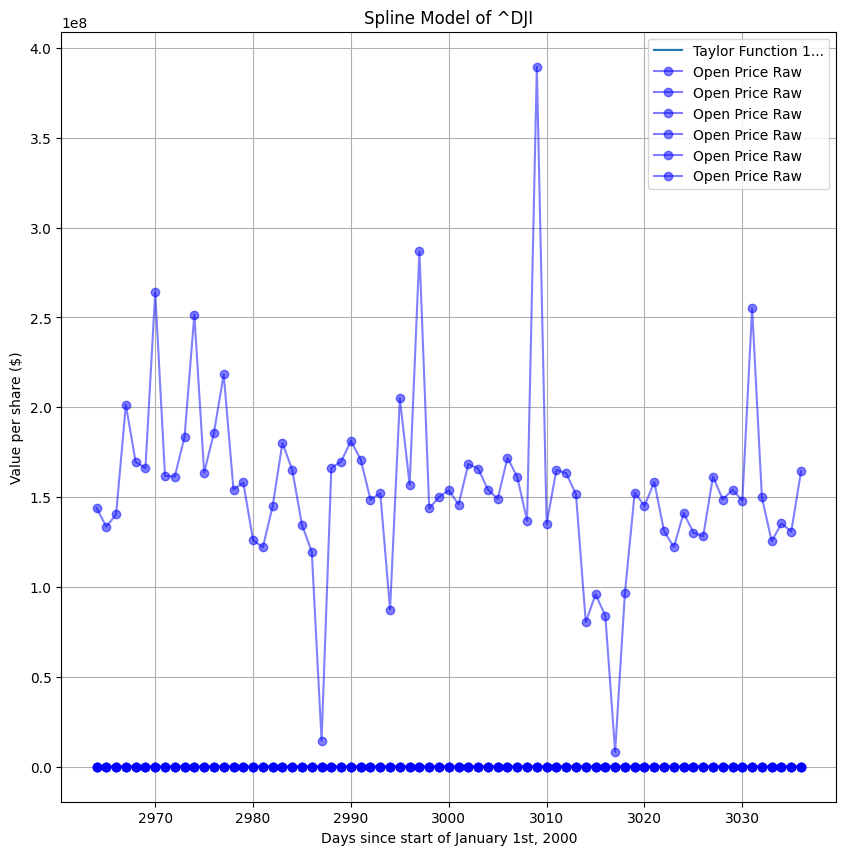

fin


In [17]:

#Data Load Variables
tickers = ["^GSPC", "^DJI", "^W5000"]
ticker = "^DJI"
Reset_data = True # Recomended (often required): Resets the data processing
start_date="2000-01-01" # Recomended
end_date="2023-12-31"# Recomended

# Data Processing Variables (affects model results)
moving_average = None # Not Recomended: value disconnect at the start day

# Model Variables (affects model results)
interval_length = 1 # The length of each spline. Days
taylor_degree = 5 # The taylor degree used in making the spline functions. Must be an int greater than 0
KNN_neighbors = 9 # The number of closest points used for KNN. Must be an int greater than 0

# Parameter Selection
use_rand_params = False
use_row_num = True # Recommended. Generates input parameters for KNN based on actual row numbers.
row_num = -1 # Builds each new spline piece from the last point
use_init_params = False
init_params = [25.16, -.25]
add_noise = False # Not Recommended. Random Noise in KNN Parameters. Not upwards

# Weights affect how the parameter inputs in KNN are prioritized. Different function options. Length must be one greater than process_taylor_degree or None
#weights = np.array([100/((i+1)**4) for i in range(taylor_degree+1)]) 
weights = np.array([(np.exp(-1*i)) for i in range(taylor_degree+1)]) # Recommended: KNN Parameter importance decays exponentially
#weights = np.array([(1/(np.log(i+4))) for i in range(taylor_degree+1)])

# Model generation
max_days = 36 # Max number of days to generate
num_of_nodes = math.floor(max_days/interval_length)  # Number of node is adjustable, or from max_days
dx = 0.1 # Resolution of model. High resolution is slower, but has slightly lower error.
start_day = 3000 # The day that the model predicts from. Day zero is the start_date generated Positive value between 0 and 6036

# Info Flags
node_info = True # Not Recomended. Prints information about the nodes
show_legend = True # Shows the label when plotting
overlap_data = True # Puts raw and predicted data on the same axes
data_show_start = start_day-max_days # Start of plotted raw data
data_show_end = start_day+max_days # End of plotted raw data

#Main function
# Validate inputs
validate_inputs()

#Ensure ticker is in the system
try:
    raw_data_file_path, processed_data_file_path = dh.get_file_path(Ticker)
except:
    Reset_data= True
    
# Data management
if Reset_data:
    dh.add_and_process_ticker(
        ticker, 
        start_date= start_date, 
        end_date= end_date, 
        process_taylor_degree = taylor_degree,
        weights= weights,
        rolling= moving_average
    )

raw_data_file_path, processed_data_file_path = dh.get_file_path(ticker)

weights= dh.get_weights(ticker)
    
# Initialize spline functions
Functions = model.Spline_functions(
    processed_data_file_path,
    ticker,
    interval_length=interval_length,
    k=KNN_neighbors,
    dx = dx,
    taylor_degree=taylor_degree,
    weights= weights,
    start_day = start_day
)

# Creates nodes based on chosen option
if use_rand_params:
    params, row = Functions.get_rand_params_from_data()
    _, _ = Functions.Create_node(params, size=num_of_nodes)
elif use_row_num:
    params, row= Functions.get_params_from_row_num(row_num)
    # Create nodes if necessary, or adjust according to needs
    _, _ = Functions.Create_node(params, size=num_of_nodes)
else:
    _, _ = Functions.Create_node(init_params, size=num_of_nodes)
    params= Init_params
    row = None

#Adjust params by weights
params= np.array(params) * weights[:len(params)]

# Plots the functions
fig, ax = Functions.graph_functions(show_legend=show_legend)

# Plots the raw data on the same axes
if overlap_data and not use_init_params:
    if row is not None:
        dh.plot(raw_data_file_path, ax, weights = weights, start=data_show_start, end=data_show_end, show_legend=show_legend, raw = True)
        #dh.plot(processed_data_file_path, ax, weights = weights, start=data_show_start, end=data_show_end, show_legend=show_legend, raw = False)

# Print node information
if node_info:
    Functions.Nodes_info(all=True)

# Final output
print(f'Total length = {num_of_nodes * interval_length / 365:.3f} years or {num_of_nodes*interval_length} days')

plt.show()

print('fin')

Text(0.5, 1, "Mean accuracy of Model: ['ticker: ^DJI', 'interval_length: 1', 'taylor_degree: 5', 'KNN: 9'] by Prediction Day")

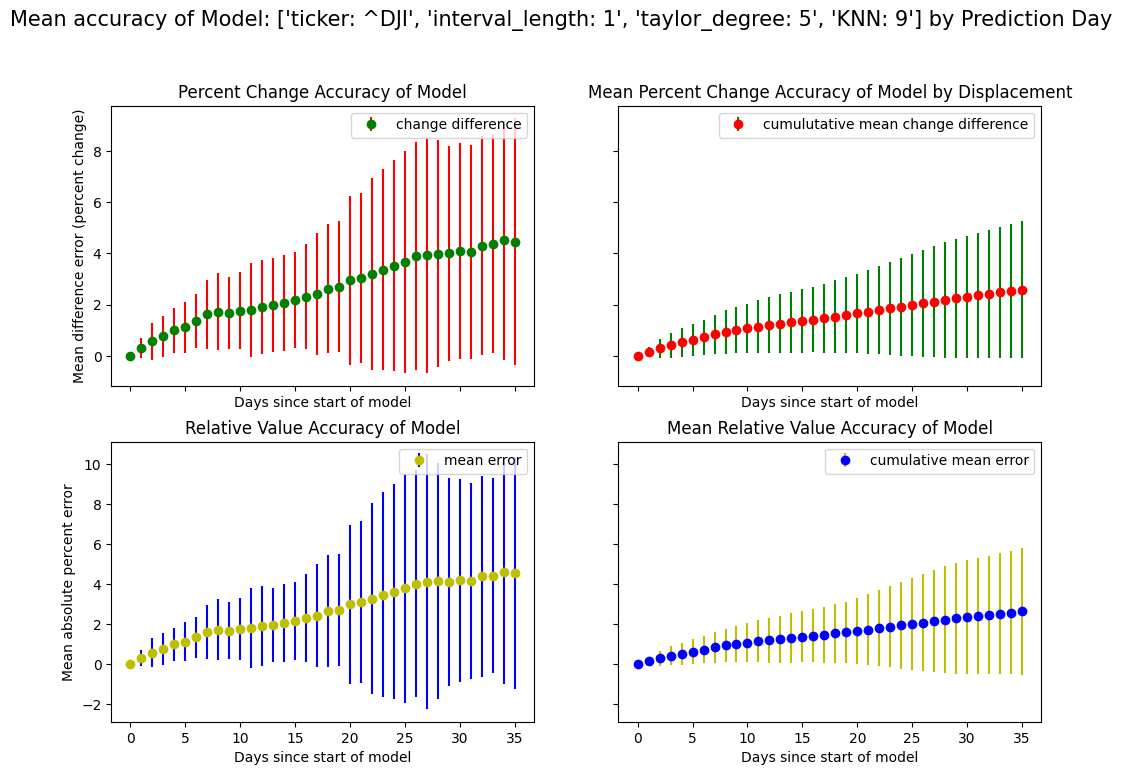

In [5]:
# Plotting the best models

model_ids = {"ticker": "^DJI", "interval_length": 1, "taylor_degree": 5, "KNN": 9}

#making a 2x2 plot of the different accuracy measures
fig, axes = plt.subplots(2,2, sharex = 'col', sharey = 'row', figsize=(12, 8))

displacement, accuracies, errs = model_analysis.access_accuracies(model_ids, accuracy_type = "relative_change", return_displacement = True)
axes[0,0].errorbar(displacement, 100*accuracies, yerr=errs*100, fmt='o', color = 'g', ecolor = 'r', label = "change difference")
axes[0,0].set_title("Percent Change Accuracy of Model")
axes[0,0].legend()

displacement, accuracies, errs = model_analysis.access_accuracies(model_ids, accuracy_type = "mean_relative_change", return_displacement = True)
axes[0,1].errorbar(displacement, 100*accuracies, yerr=errs*100, fmt='o', color = 'r', ecolor = 'g', label = "cumulutative mean change difference")
axes[0,1].set_title("Mean Percent Change Accuracy of Model by Displacement")
axes[0,1].legend()

displacement, accuracies, errs = model_analysis.access_accuracies(model_ids, accuracy_type = "value", return_displacement = True)
axes[1,0].errorbar(displacement, 100*accuracies, yerr=errs*100, fmt='o', color = 'y', ecolor = 'b', label = "mean error")
axes[1,0].set_title("Relative Value Accuracy of Model")
axes[1,0].legend()

displacement, accuracies, errs = model_analysis.access_accuracies(model_ids, accuracy_type = "mean_value", return_displacement = True)
axes[1,1].errorbar(displacement, 100*accuracies, yerr=errs*100, fmt='o', color = 'b', ecolor = 'y', label = "cumulative mean error")
axes[1,1].set_title("Mean Relative Value Accuracy of Model")
axes[1,1].legend()

axes[1, 0].set_xlabel('Days since start of model', fontsize=10)
axes[1, 1].set_xlabel('Days since start of model', fontsize=10)
axes[0, 1].set_xlabel('Days since start of model', fontsize=10)
axes[0, 0].set_xlabel('Days since start of model', fontsize=10)
axes[0, 0].set_ylabel('Mean difference error (percent change)', fontsize=10)
axes[1, 0].set_ylabel('Mean absolute percent error', fontsize=10)

#plt.tight_layout()

plt.suptitle(f'Mean accuracy of Model: {[f'{id}: {model_ids[id]}' for id in model_ids]} by Prediction Day', fontsize=15, y = 1)


This next cell loops through a lot of data that we previously predicted to find the set of model input parameters that best minimizes error according to a chosen accuracy type and ticker.

In [10]:
def get_min_accuracy(ticker_ids, accuracies, errs):
    index = np.argmin(np.abs(accuracies)) #accuracies are technically errors, so I pick min
    min_accuracy = accuracies[index]
    min_err = errs[index]
    min_model = ticker_ids[index]
    return min_model, min_accuracy, min_err

In [22]:
days_wanted = 15 # Optimizes based on desired prediction range. Max is 36 for the saved data
accuracy_types = ["mean_relative_change", "relative_change", "mean_value", "value"] # Different accuracy types
accuracy_type = "mean_relative_change"
tickers = ["^GSPC", "^DJI", "^W5000"] # Tickers with availiable data

# Loops through model inputs to find the best one for each ticker according to derired accuracy type and prediction range.

for ticker in tickers:
    print(ticker)
    
    ticker_input_accuracies = []
    ticker_week_accuracies = []
    ticker_month_accuracies = []

    ticker_input_errs = []
    ticker_week_errs = []
    ticker_month_errs = []

    ticker_ids = []
    
    raw_data_file_path = dh.get_file_path(ticker)
        
    interval_lengths = np.arange(1,6,1)
    for interval_length in interval_lengths:
                    
        taylor_degrees = np.arange(1,11,1)
        for taylor_degree in taylor_degrees:
                            
            KNN_neighborses = np.arange(1,12,2)
            for KNN_neighbors in KNN_neighborses:

                # An identifier for the different input param combos
                model_ids = {"ticker": ticker, "interval_length": interval_length, "taylor_degree": taylor_degree, "KNN": KNN_neighbors}

                # Retrieves accuracies and errs from their storage
                accuracies, errs = model_analysis.access_accuracies(model_ids, accuracy_type = accuracy_type)

                # For use in finding the min err
                ticker_week_accuracies.append(accuracies[31])
                ticker_month_accuracies.append(accuracies[7])
                ticker_input_accuracies.append(accuracies[days_wanted])

                ticker_week_errs.append(errs[31])
                ticker_month_errs.append(errs[7])
                ticker_input_errs.append(errs[days_wanted])

                ticker_ids.append(model_ids)

    
    #months
    month_model, month_accuracy, month_err = get_min_accuracy(ticker_ids, ticker_month_accuracies, ticker_month_errs)

    #weeks
    week_model, week_accuracy, week_err = get_min_accuracy(ticker_ids, ticker_week_accuracies, ticker_week_errs)

    #input
    input_model, input_accuracy, input_err = get_min_accuracy(ticker_ids, ticker_input_accuracies, ticker_input_errs)
    
    
    # Output the best models
    if month_model:
        print(f"The best params identified for 1 month displacement on the {ticker} market curve are {([f'{id}: {month_model[id]}' for id in month_model])}, with a mean relative change value of {month_accuracy:.5f} +/- {month_err:.5f}")
    else:
        print(f"No valid params found for 1 month displacement on the {ticker} market curve.")
    
    if week_model:
        print(f"The best params identified for 1 week displacement on the {ticker} market curve are {([f'{id}: {week_model[id]}' for id in week_model])}, with a mean relative change value of {week_accuracy:.5f} +/- {week_err:.5f}")
    else:
        print(f"No valid params found for 1 week displacement on the {ticker} market curve.")
    
    if input_model:
        print(f"The best params identified for {days_wanted} days on the {ticker} market curve are {([f'{id}: {input_model[id]}' for id in input_model])}, with a mean relative change value of {input_accuracy:.5f} +/- {input_err:.5f}")
    else:
        print(f"No valid models found for {days_wanted} week displacement on the {ticker} market curve.")

print("fin")

^GSPC
The best params identified for 1 month displacement on the ^GSPC market curve are ['ticker: ^GSPC', 'interval_length: 1', 'taylor_degree: 10', 'KNN: 1'], with a mean relative change value of 0.00662 +/- 0.00654
The best params identified for 1 week displacement on the ^GSPC market curve are ['ticker: ^GSPC', 'interval_length: 1', 'taylor_degree: 10', 'KNN: 5'], with a mean relative change value of 0.02206 +/- 0.02174
The best params identified for 15 days on the ^GSPC market curve are ['ticker: ^GSPC', 'interval_length: 1', 'taylor_degree: 8', 'KNN: 5'], with a mean relative change value of 0.01223 +/- 0.01083
^DJI
The best params identified for 1 month displacement on the ^DJI market curve are ['ticker: ^DJI', 'interval_length: 2', 'taylor_degree: 10', 'KNN: 1'], with a mean relative change value of 0.00642 +/- 0.00661
The best params identified for 1 week displacement on the ^DJI market curve are ['ticker: ^DJI', 'interval_length: 2', 'taylor_degree: 9', 'KNN: 9'], with a mean 

The next cell makes a big plot of the accuracies for a chosen model. The chosen model is currently set to the best 1 week displacement for DJI

WARNING: Proceed with caution.

CAUTION: Running Different Variations. Will take a long time.

In [ ]:
#Prepare data variables

# Data Tickers
tickers = ["^GSPC", "^DJI", "^W5000"]

# Data Load Variables
Reset_data = True #Must be true inorder for following to take effect
start_date="2000-01-01" 
end_date="2023-12-31"
raw_data_file_path, processed_data_file_path = dh.get_file_path(ticker)
moving_average = None

# Parameter Selection
row_num = -1
add_noise = False #(affects model results)
weights= None #Length must be one greater than process_taylor_degree or None

# Additional_variables (affects model results)
dx = 0.1
max_days = 36
num_tests = 100

# Info Flags
node_info = False

In [ ]:
#Check Looping

count = 0
for ticker in tickers:
    
    interval_lengths = np.arange(1,6,1)
    for interval_length in interval_lengths:
        interval_length = int(interval_length)
        
        taylor_degrees = np.arange(1,11,1)
        for taylor_degree in taylor_degrees:
            taylor_degree = int(taylor_degree)
                
            KNN_neighborses = np.arange(1,12,2)
            for KNN_neighbors in KNN_neighborses:
                KNN_neighbors = int(KNN_neighbors)

                weights = np.array([(100*np.exp(-1*i)) for i in range(taylor_degree+1)])
                
                validate_inputs()
                count += 1

print("valid ranges")
print(count, "cycles")

In [ ]:
#Clear current data
#model_analysis.clear_path()

In [ ]:
#Loop and save prediction data: For optimization and bootstraping
count = 0

for ticker in tickers:
    print(ticker)
    raw_data_file_path, processed_data_file_path = dh.get_file_path(ticker)
    
    interval_lengths = np.arange(1,6,1)
    for interval_length in interval_lengths:
        
        num_of_nodes = math.floor(max_days/interval_length)
        
        taylor_degrees = np.arange(1,11,1)
        for taylor_degree in taylor_degrees:
            
            weights = np.array([(100*np.exp(-1*i)) for i in range(taylor_degree+1)])
            
            KNN_neighborses = np.arange(1,12,2)
            for KNN_neighbors in KNN_neighborses:
                
                # Data management
                dh.add_and_process_ticker(
                    ticker, 
                    start_date= start_date, 
                    end_date= end_date, 
                    process_taylor_degree = taylor_degree,
                    weights= weights,
                    rolling= moving_average)
                
                weights= dh.get_weights(ticker)
                
                model_ids = {"ticker": ticker, "interval_length": interval_length, "taylor_degree": taylor_degree, "KNN": KNN_neighbors}
                
                #generate starts
                start_days = model_analysis.generate_test_regions(processed_data_file_path, max_days = max_days, num_tests = num_tests, lower = 2*365, upper = -1)
                
                #loop over starts for bootstrapping
                predictions = np.empty((num_tests,interval_length*num_of_nodes))
                for i,start_day in enumerate(start_days):
                
                    # Initialize spline functions
                    Functions = model.Spline_functions(
                        processed_data_file_path,
                        ticker,
                        interval_length=interval_length,
                        k=KNN_neighbors,
                        dx = dx,
                        taylor_degree=taylor_degree,
                        weights= weights,
                        start_day = start_day
                    )
                    
                    # Create nodes and and initial parameters
                    params, row= Functions.get_params_from_row_num(row_num)
                    _, _ = Functions.Create_node(params, size=num_of_nodes)
                
                    params= np.array(params) * weights[:len(params)]
                
                    #retrieve data
                    _, prediction = Functions.get_prediction_data()
                    
                    predictions[i, :] = prediction
                
                #stores data
                model_analysis.save_predictions(predictions, model_ids, start_days = start_days)

                count += 1
                print(count)

print("fin")

In [ ]:
#Calculate analysis and save over loop
count = 0

for ticker in tickers:
    print(ticker)
    
    raw_data_file_path = dh.get_file_path(ticker)
    
    interval_lengths = np.arange(1,6,1)
    for interval_length in interval_lengths:
                
        taylor_degrees = np.arange(1,11,1)
        for taylor_degree in taylor_degrees:
                        
            KNN_neighborses = np.arange(1,12,2)
            for KNN_neighbors in KNN_neighborses:

                model_ids = {"ticker": ticker, "interval_length": interval_length, "taylor_degree": taylor_degree, "KNN": KNN_neighbors}

                start_days, predictions = model_analysis.access_predictions(model_ids)
                
                Analysis = model_analysis.analysis(raw_data_file_path, predictions, start_days)
                
                relative_change_accuracies, relative_change_errs = Analysis.relative_change_accuracy()
                model_analysis.save_accuracies(relative_change_accuracies, relative_change_errs, model_ids, accuracy_type  = "relative_change")
                
                mean_relative_change_accuracies, mean_relative_change_errs = Analysis.mean_relative_change_accuracy()
                model_analysis.save_accuracies(mean_relative_change_accuracies, mean_relative_change_errs, model_ids, accuracy_type  = "mean_relative_change")
                
                value_accuracies, value_errs = Analysis.value_accuracy()
                model_analysis.save_accuracies(value_accuracies, value_errs, model_ids, accuracy_type  = "value")
                
                mean_value_accuracies, mean_value_errs = Analysis.mean_value_accuracy()
                model_analysis.save_accuracies(mean_value_accuracies, mean_value_errs, model_ids, accuracy_type  = "mean_value")

                count +=1
                print(count)

In [ ]:
count = 0
for ticker in tickers:
    
    interval_lengths = np.arange(1,6,1)
    for interval_length in interval_lengths:
        interval_length = int(interval_length)
        
        taylor_degrees = np.arange(1,11,1)
        for taylor_degree in taylor_degrees:
            taylor_degree = int(taylor_degree)
                
            KNN_neighborses = np.arange(1,12,2)
            for KNN_neighbors in KNN_neighborses:
                KNN_neighbors = int(KNN_neighbors)
                
                model_ids = {"ticker": ticker, "interval_length": interval_length, "taylor_degree": taylor_degree, "KNN": KNN_neighbors}
                model_analysis.clear_path(ids)

                count += 1

print(count, "cycles")

In [7]:
#Calculate to save accuracies

count = 0

for ticker in tickers:
    print(ticker)
    
    raw_data_file_path, _ = dh.get_file_path(ticker)
    
    interval_lengths = np.arange(1,6,1)
    for interval_length in interval_lengths:
                
        taylor_degrees = np.arange(1,11,1)
        for taylor_degree in taylor_degrees:
                        
            KNN_neighborses = np.arange(1,12,2)
            for KNN_neighbors in KNN_neighborses:

                model_ids = {"ticker": ticker, "interval_length": interval_length, "taylor_degree": taylor_degree, "KNN": KNN_neighbors}

                start_days, predictions = model_analysis.access_predictions(model_ids)
                
                Analysis = model_analysis.analysis(raw_data_file_path, predictions, start_days)
                
                relative_change_accuracies, relative_change_errs = Analysis.relative_change_accuracy()
                model_analysis.save_accuracies(relative_change_accuracies, relative_change_errs, model_ids, accuracy_type  = "relative_change", overwrite = True)
                
                mean_relative_change_accuracies, mean_relative_change_errs = Analysis.mean_relative_change_accuracy()
                model_analysis.save_accuracies(mean_relative_change_accuracies, mean_relative_change_errs, model_ids, accuracy_type  = "mean_relative_change")
                
                value_accuracies, value_errs = Analysis.value_accuracy()
                model_analysis.save_accuracies(value_accuracies, value_errs, model_ids, accuracy_type  = "value")
                
                mean_value_accuracies, mean_value_errs = Analysis.mean_value_accuracy()
                model_analysis.save_accuracies(mean_value_accuracies, mean_value_errs, model_ids, accuracy_type  = "mean_value")

                count +=1
                print(count)

^GSPC
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27